In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from timm.models.swin_transformer import SwinTransformer
from PIL import Image
import time
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Callback classes
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pth')
        self.val_loss_min = val_loss

class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=False):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = np.Inf if mode == 'min' else -np.Inf

    def __call__(self, metrics, model):
        current = metrics[self.monitor]
        if (self.mode == 'min' and current < self.best) or (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'Model improved from {self.best:.4f} to {current:.4f}. Saving model...')
            self.best = current
            torch.save(model.state_dict(), self.filepath)
        elif not self.save_best_only:
            torch.save(model.state_dict(), self.filepath)

In [3]:
class MilkAdulterationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = []
        self.transform = transform

        # Define the 5 classes
        self.class_map = {
            "None": 0,
            "Detergent": 1,
            "Shampoo": 2,
            "StarchPowder": 3,
            "Water": 4
        }

        for fat in os.listdir(root_dir):
            fat_path = os.path.join(root_dir, fat)
            if not os.path.isdir(fat_path):
                continue

            for percent in os.listdir(fat_path):
                percent_path = os.path.join(fat_path, percent)

                if percent == '0':
                    # No adulterant
                    for img_name in os.listdir(percent_path):
                        self.data.append({
                            "img_path": os.path.join(percent_path, img_name),
                            "label": self.class_map["None"]
                        })
                else:
                    # With adulterant
                    for adulterant in os.listdir(percent_path):
                        adulterant_path = os.path.join(percent_path, adulterant)
                        label_name = adulterant if adulterant in self.class_map else "None"
                        for img_name in os.listdir(adulterant_path):
                            self.data.append({
                                "img_path": os.path.join(adulterant_path, img_name),
                                "label": self.class_map[label_name]
                            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = Image.open(sample["img_path"]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, sample["label"]

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
data_dir = '/home/nitin/salmaan/RGB'
dataset = MilkAdulterationDataset(data_dir, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


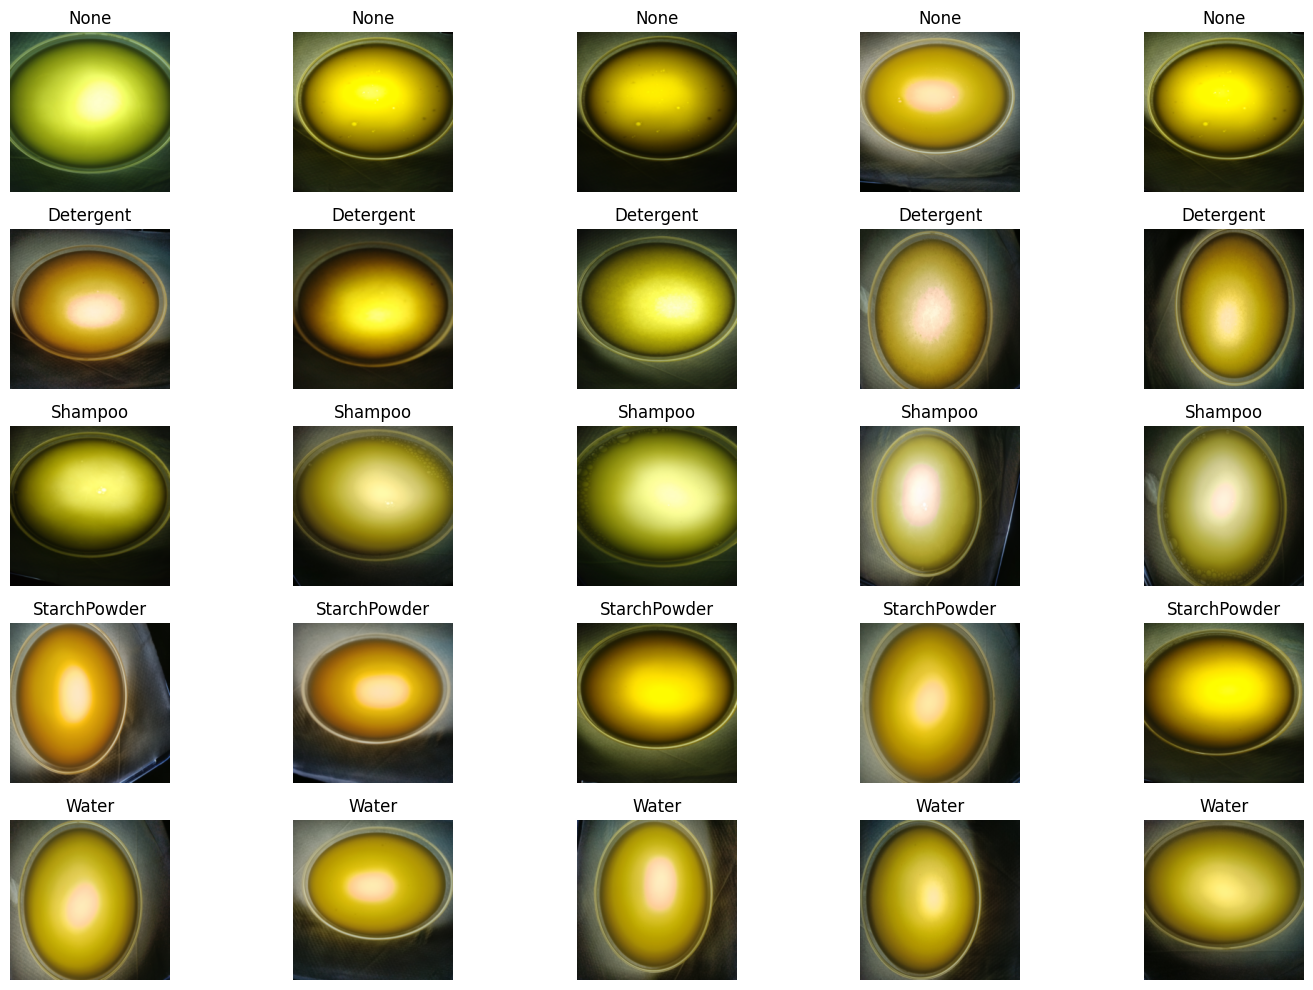

In [7]:
import random

inverse_class_map = {v: k for k, v in dataset.class_map.items()}

# Organize images by class
class_images = {class_id: [] for class_id in dataset.class_map.values()}

for idx in range(len(dataset)):
    image, label = dataset[idx]
    class_images[label].append((image, label))

# Set up the plot
fig, axes = plt.subplots(len(dataset.class_map), 5, figsize=(15, 10))
axes = axes.flatten()

# For each class, plot 5 random images
for i, (class_id, images) in enumerate(class_images.items()):
    random_images = random.sample(images, 5)  # Randomly sample 5 images
    for j, (image, label) in enumerate(random_images):
        ax = axes[i * 5 + j]
        
        # Convert image tensor to numpy array
        image_np = image.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Convert from CHW to HWC format
        
        # Check if the image is normalized and unnormalize if needed
        # If the image is normalized, you might want to multiply by 255 and convert to uint8
        # if image_np.max() <= 1.0:  # If the values are between 0 and 1 (normalized)
        #     image_np = (image_np * 255).astype(np.uint8)
        
        ax.imshow(image_np)  # Display image
        ax.axis('off')
        ax.set_title(inverse_class_map[label])

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for intege

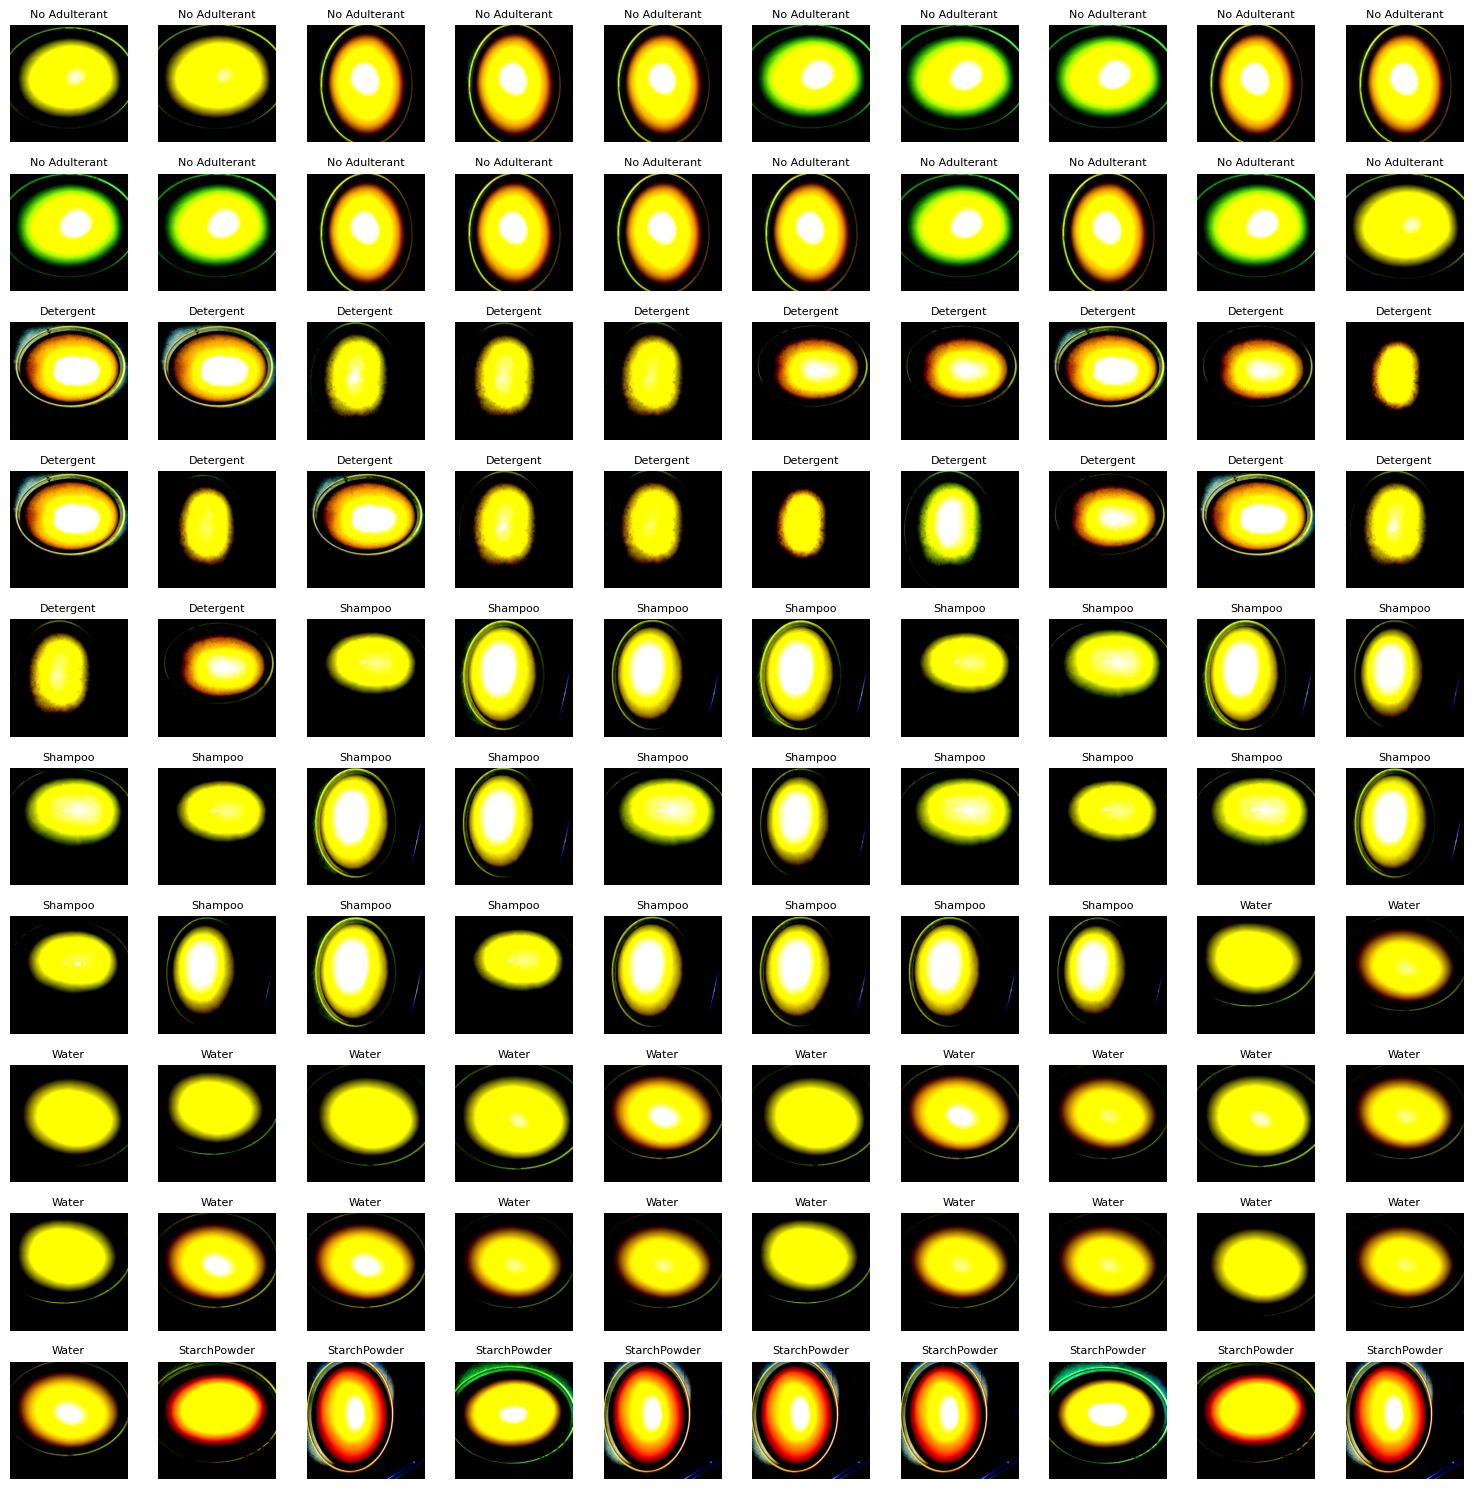

In [9]:
index_to_class = {
    0: "No Adulterant",
    1: "Detergent",
    2: "Shampoo",
    3: "StarchPowder",
    4: "Water"
}

fig, axs = plt.subplots(10, 10, figsize=(15, 15))

for i in range(100):  # Loop through 100 images
    img, label = dataset[i]  # Get image and label
    img = img.permute(1, 2, 0)  # Convert from CHW to HWC format
    row, col = divmod(i, 10)  # Get row and column index

    axs[row, col].imshow(img)
    axs[row, col].set_title(index_to_class[label], fontsize=8)
    axs[row, col].axis('off')  # Hide axes for cleaner look

plt.tight_layout()
plt.show()

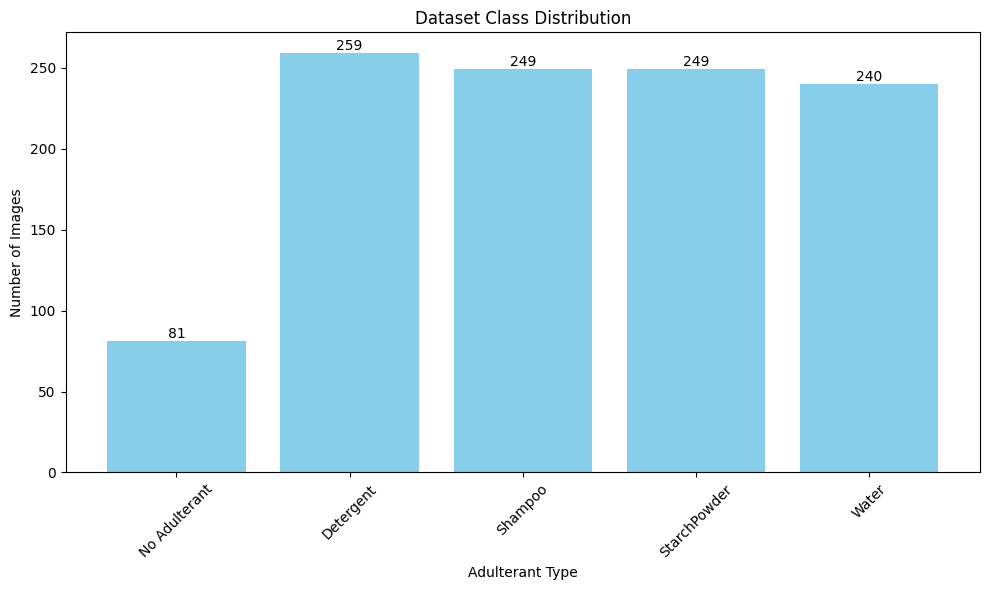

In [10]:
from collections import Counter

all_labels = [sample["label"] for sample in dataset.data]
label_counts = Counter(all_labels)  # Count occurrences of each label

# Map class indices to names
index_to_class = {
    0: "No Adulterant",
    1: "Detergent",
    2: "Shampoo",
    3: "StarchPowder",
    4: "Water"
}

# Prepare data for plotting
class_names = [index_to_class[i] for i in range(len(index_to_class))]
counts = [label_counts[i] for i in range(len(index_to_class))]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, counts, color='skyblue')

# Add counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.xlabel("Adulterant Type")
plt.ylabel("Number of Images")
plt.title("Dataset Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# Print dataset sizes
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 754
Validation size: 107
Test size: 217


In [12]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(dataset.class_map)
print(f"Number of classes: {num_classes}")

Number of classes: 5


In [13]:
model = SwinTransformer(
    img_size=224,
    patch_size=4,
    in_chans=3,
    num_classes=num_classes,
    embed_dim=96,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    window_size=7,
    pretrained=True
)

In [14]:
device_list = [0,1,2,3,4,5,6]

In [15]:
print(f"CUDA devices available: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

CUDA devices available: 7
Device 0: NVIDIA A100-SXM4-40GB
Device 1: NVIDIA A100-SXM4-40GB
Device 2: NVIDIA A100-SXM4-40GB
Device 3: NVIDIA A100-SXM4-40GB
Device 4: NVIDIA A100-SXM4-40GB
Device 5: NVIDIA A100-SXM4-40GB
Device 6: NVIDIA A100-SXM4-40GB


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(f'cuda:{device_list[0]}')

if torch.cuda.device_count() > 1:
    print(f"Using {len(device_list)} GPUs!")
    model = nn.DataParallel(model, device_ids=device_list)

Using 7 GPUs!


In [17]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Initialize callbacks
early_stopping = EarlyStopping(patience=5, verbose=True)
model_checkpoint = ModelCheckpoint('best_model.pth', monitor='val_loss', mode='min', verbose=True)

/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_acc = 0.0
    best_model_wts = None
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Wrap train_loader with tqdm for progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f'Train Epoch {epoch}')
        for inputs, labels in train_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                if outputs.dim() > 2:
                    outputs = outputs.view(outputs.size(0), -1)
                
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Update progress bar
            train_loader_tqdm.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.cpu().numpy())
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Validation Epoch {epoch}'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                if outputs.dim() > 2:
                    outputs = outputs.view(outputs.size(0), -1)
                
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_epoch_loss = val_running_loss / len(val_dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_dataset)
        
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc.cpu().numpy())
        
        # Print epoch results
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
        
        # Step the scheduler
        scheduler.step(val_epoch_loss)
        
        # Callbacks
        metrics = {'val_loss': val_epoch_loss, 'val_acc': val_epoch_acc}
        model_checkpoint(metrics, model.module if hasattr(model, 'module') else model)
        early_stopping(val_epoch_loss, model.module if hasattr(model, 'module') else model)
        
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
        
        # Update best model
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = model.state_dict().copy()
            torch.save(best_model_wts, 'swin_best.pth')
            print('New best model saved!')
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [37]:
num_epochs = 30
trained_model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, criterion, optimizer, scheduler, num_epochs=num_epochs
)

Epoch 0/29
----------


Train Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 1.8043 Acc: 0.2626
Val Loss: 1.3806 Acc: 0.4486
Model improved from inf to 1.3806. Saving model...
Validation loss decreased (inf --> 1.380585). Saving model...
New best model saved!

Epoch 1/29
----------


Train Epoch 1:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 1.3010 Acc: 0.4390
Val Loss: 1.1499 Acc: 0.5701
Model improved from 1.3806 to 1.1499. Saving model...
Validation loss decreased (1.380585 --> 1.149906). Saving model...
New best model saved!

Epoch 2/29
----------


Train Epoch 2:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 1.1889 Acc: 0.4907
Val Loss: 1.1219 Acc: 0.5607
Model improved from 1.1499 to 1.1219. Saving model...
Validation loss decreased (1.149906 --> 1.121905). Saving model...

Epoch 3/29
----------


Train Epoch 3:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 1.0390 Acc: 0.5650
Val Loss: 0.9251 Acc: 0.6449
Model improved from 1.1219 to 0.9251. Saving model...
Validation loss decreased (1.121905 --> 0.925082). Saving model...
New best model saved!

Epoch 4/29
----------


Train Epoch 4:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 0.8595 Acc: 0.6605
Val Loss: 0.7799 Acc: 0.7196
Model improved from 0.9251 to 0.7799. Saving model...
Validation loss decreased (0.925082 --> 0.779883). Saving model...
New best model saved!

Epoch 5/29
----------


Train Epoch 5:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 0.7439 Acc: 0.7029
Val Loss: 0.7823 Acc: 0.7196
EarlyStopping counter: 1 out of 5

Epoch 6/29
----------


Train Epoch 6:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 0.5785 Acc: 0.7732
Val Loss: 0.5486 Acc: 0.7290
Model improved from 0.7799 to 0.5486. Saving model...
Validation loss decreased (0.779883 --> 0.548590). Saving model...
New best model saved!

Epoch 7/29
----------


Train Epoch 7:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 0.5395 Acc: 0.7905
Val Loss: 0.5503 Acc: 0.7757
EarlyStopping counter: 1 out of 5
New best model saved!

Epoch 8/29
----------


Train Epoch 8:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 0.5002 Acc: 0.8210
Val Loss: 0.6203 Acc: 0.7757
EarlyStopping counter: 2 out of 5

Epoch 9/29
----------


Train Epoch 9:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 0.4636 Acc: 0.8223
Val Loss: 0.3272 Acc: 0.8692
Model improved from 0.5486 to 0.3272. Saving model...
Validation loss decreased (0.548590 --> 0.327243). Saving model...
New best model saved!

Epoch 10/29
----------


Train Epoch 10:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.2929 Acc: 0.8952
Val Loss: 0.2277 Acc: 0.9159
Model improved from 0.3272 to 0.2277. Saving model...
Validation loss decreased (0.327243 --> 0.227683). Saving model...
New best model saved!

Epoch 11/29
----------


Train Epoch 11:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.3142 Acc: 0.8926
Val Loss: 0.3341 Acc: 0.8879
EarlyStopping counter: 1 out of 5

Epoch 12/29
----------


Train Epoch 12:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.3039 Acc: 0.9005
Val Loss: 0.2181 Acc: 0.9159
Model improved from 0.2277 to 0.2181. Saving model...
Validation loss decreased (0.227683 --> 0.218095). Saving model...

Epoch 13/29
----------


Train Epoch 13:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.1644 Acc: 0.9443
Val Loss: 0.1180 Acc: 0.9626
Model improved from 0.2181 to 0.1180. Saving model...
Validation loss decreased (0.218095 --> 0.117971). Saving model...
New best model saved!

Epoch 14/29
----------


Train Epoch 14:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.1452 Acc: 0.9536
Val Loss: 0.1396 Acc: 0.9439
EarlyStopping counter: 1 out of 5

Epoch 15/29
----------


Train Epoch 15:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.2359 Acc: 0.9204
Val Loss: 0.0780 Acc: 0.9907
Model improved from 0.1180 to 0.0780. Saving model...
Validation loss decreased (0.117971 --> 0.077964). Saving model...
New best model saved!

Epoch 16/29
----------


Train Epoch 16:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0948 Acc: 0.9735
Val Loss: 0.0767 Acc: 0.9626
Model improved from 0.0780 to 0.0767. Saving model...
Validation loss decreased (0.077964 --> 0.076700). Saving model...

Epoch 17/29
----------


Train Epoch 17:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0834 Acc: 0.9708
Val Loss: 0.0213 Acc: 1.0000
Model improved from 0.0767 to 0.0213. Saving model...
Validation loss decreased (0.076700 --> 0.021345). Saving model...
New best model saved!

Epoch 18/29
----------


Train Epoch 18:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0354 Acc: 0.9947
Val Loss: 0.0136 Acc: 1.0000
Model improved from 0.0213 to 0.0136. Saving model...
Validation loss decreased (0.021345 --> 0.013611). Saving model...

Epoch 19/29
----------


Train Epoch 19:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0212 Acc: 0.9934
Val Loss: 0.0173 Acc: 0.9907
EarlyStopping counter: 1 out of 5

Epoch 20/29
----------


Train Epoch 20:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0176 Acc: 0.9973
Val Loss: 0.0225 Acc: 1.0000
EarlyStopping counter: 2 out of 5

Epoch 21/29
----------


Train Epoch 21:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0135 Acc: 0.9973
Val Loss: 0.0420 Acc: 0.9907
EarlyStopping counter: 3 out of 5

Epoch 22/29
----------


Train Epoch 22:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0138 Acc: 0.9947
Val Loss: 0.0213 Acc: 0.9907
EarlyStopping counter: 4 out of 5

Epoch 23/29
----------


Train Epoch 23:   0%|          | 0/24 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0099 Acc: 0.9987
Val Loss: 0.0157 Acc: 0.9907
EarlyStopping counter: 5 out of 5
Early stopping triggered
Training complete in 119m 5s
Best val Acc: 1.0000


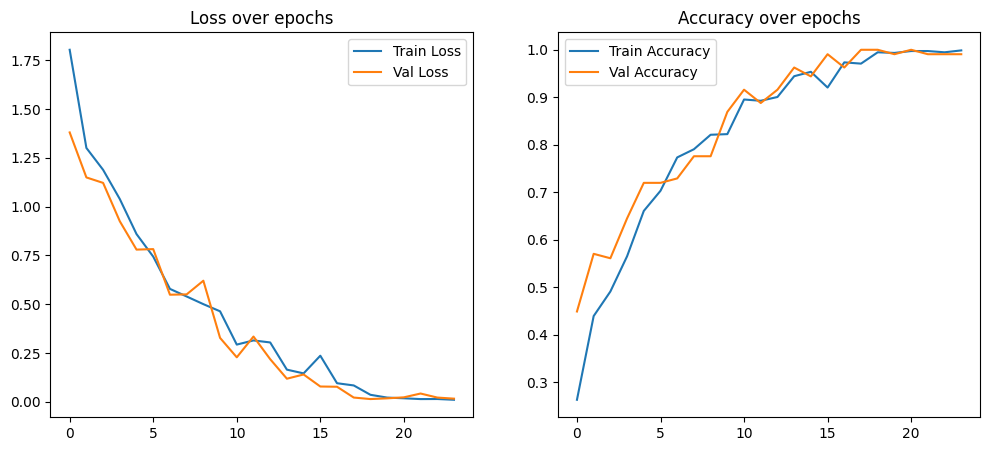

In [38]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [44]:
def evaluate_model(model, test_loader, device, criterion, num_classes, class_names=None):
    model.eval()
    
    all_preds = []
    all_labels = []
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Test accuracy and loss
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100 * correct / total
    
    # Calculate overall precision, recall, and f1-score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Print results
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision (weighted): {precision:.2f}")
    print(f"Recall (weighted): {recall:.2f}")
    print(f"F1 Score (weighted): {f1:.2f}")
    
    # Classification report
    print("\nClassification Report:")
    target_names = class_names if class_names else [str(i) for i in range(num_classes)]
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return avg_test_loss, test_accuracy, all_preds, all_labels

In [45]:
def plot_test_metrics(test_loss, test_accuracy, train_loss_history=None, val_loss_history=None, train_acc_history=None, val_acc_history=None):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    if train_loss_history and val_loss_history:
        ax1.plot(train_loss_history, label='Train Loss')
        ax1.plot(val_loss_history, label='Val Loss')
        ax1.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    else:
        ax1.axhline(y=test_loss, color='r', label='Test Loss')
    ax1.set_title('Loss Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracy
    if train_acc_history and val_acc_history:
        ax2.plot(train_acc_history, label='Train Accuracy')
        ax2.plot(val_acc_history, label='Val Accuracy')
        ax2.axhline(y=test_accuracy/100, color='r', linestyle='--', label='Test Accuracy')
    else:
        ax2.axhline(y=test_accuracy/100, color='r', label='Test Accuracy')
    ax2.set_title('Accuracy Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [46]:
model.eval()

DataParallel(
  (module): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=Tru


Evaluating on test set...


Testing:   0%|          | 0/7 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Testing: 100%|

Test Loss: 0.0572
Test Accuracy: 98.16%
Precision (weighted): 0.98
Recall (weighted): 0.98
F1 Score (weighted): 0.98

Classification Report:
              precision    recall  f1-score   support

        None       0.95      0.95      0.95        19
   Detergent       0.96      1.00      0.98        46
     Shampoo       1.00      0.99      0.99        68
StarchPowder       1.00      0.97      0.99        40
       Water       0.98      0.98      0.98        44

    accuracy                           0.98       217
   macro avg       0.98      0.98      0.98       217
weighted avg       0.98      0.98      0.98       217



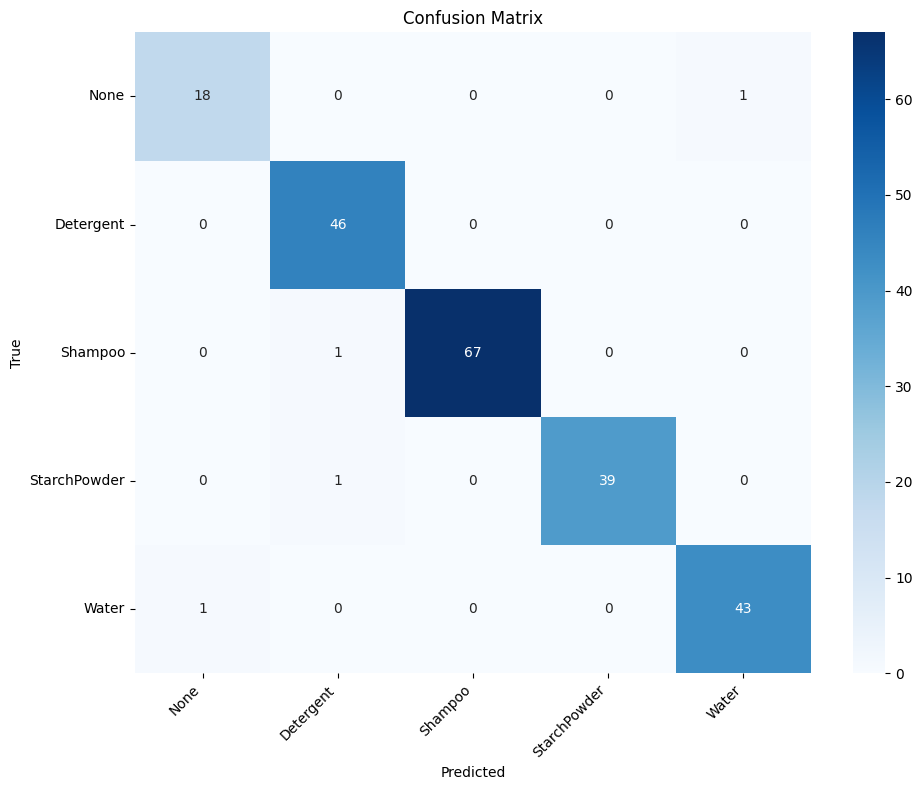

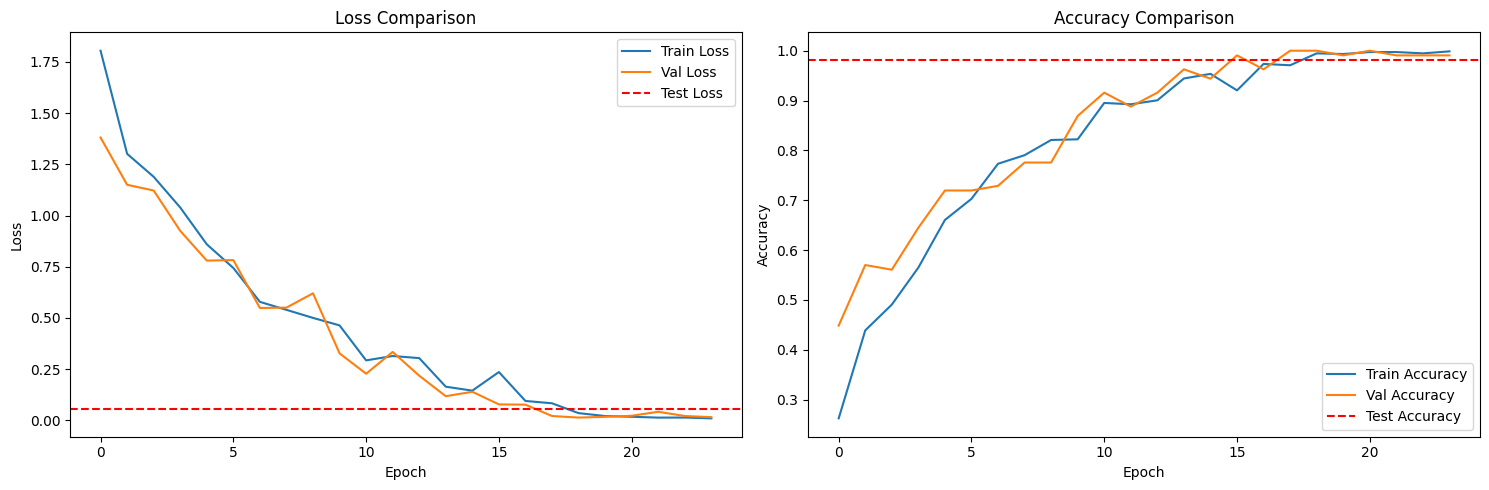

In [47]:
print("\nEvaluating on test set...")
test_loss, test_accuracy, test_preds, test_labels = evaluate_model(
    model, 
    test_loader, 
    device, 
    criterion,  # Your loss function
    num_classes,
    class_names=list(dataset.class_map)
)

# Plot test metrics alongside training history
plot_test_metrics(
    test_loss, 
    test_accuracy,
    train_loss, 
    val_loss,   
    train_acc, 
    val_acc     
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


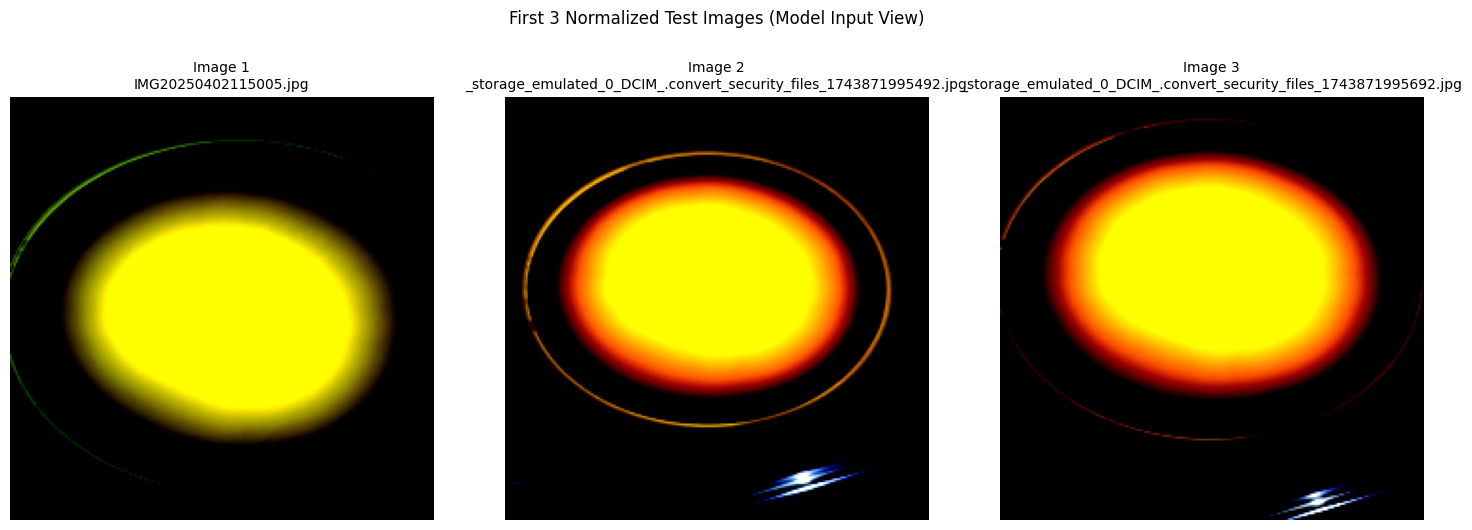

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Class mapping
index_to_class = {
    0: "No Adulterant",
    1: "Detergent",
    2: "Shampoo",
    3: "StarchPowder",
    4: "Water"
}

# Load first 3 test images
test_dir = 'test_data'
test_images = [os.path.join(test_dir, f) for f in sorted(os.listdir(test_dir)) 
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:3]  # Only first 3

# Create 1x3 grid
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, img_path in enumerate(test_images):
    # Load and process image
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img)
    img_np = img_tensor.numpy().transpose(1, 2, 0)  # CHW -> HWC
    
    # Display normalized image
    axs[i].imshow(img_np)
    axs[i].set_title(f"Image {i+1}\n{os.path.basename(img_path)}", fontsize=10)
    axs[i].axis('off')

plt.suptitle("First 3 Normalized Test Images (Model Input View)", y=1.05)
plt.tight_layout()
plt.show()

In [20]:
model = SwinTransformer(
    img_size=224,
    patch_size=4,
    in_chans=3,
    num_classes=5,  # For your 5 classes
    embed_dim=96,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    window_size=7,
    pretrained=False  # Important: set False when loading your weights
)

# 2. Load the trained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model = model.to(device)
model.eval()  # Set to evaluation mode

# 3. Make predictions
with torch.no_grad():
    for i, img_path in enumerate(test_images[:3]):
        # Get the preprocessed tensor (from previous code)
        img_tensor = transform(Image.open(img_path)).unsqueeze(0).to(device)
        
        # Get prediction
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)[0] * 100
        _, pred = torch.max(output, 1)
        
        # Print results
        print(f"\nImage {i+1}: {os.path.basename(img_path)}")
        print(f"Predicted: {index_to_class[pred.item()]}")
        print("Confidence scores:")
        for class_idx, prob in enumerate(probs):
            print(f"{index_to_class[class_idx]}: {prob:.1f}%")


/tmp/ipykernel_680775/450582179.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_location=device))



Image 1: IMG20250402115005.jpg
Predicted: Water
Confidence scores:
No Adulterant: 0.6%
Detergent: 0.0%
Shampoo: 0.0%
StarchPowder: 0.0%
Water: 99.4%

Image 2: _storage_emulated_0_DCIM_.convert_security_files_1743871995492.jpg
Predicted: Detergent
Confidence scores:
No Adulterant: 0.1%
Detergent: 63.1%
Shampoo: 0.0%
StarchPowder: 36.8%
Water: 0.0%

Image 3: _storage_emulated_0_DCIM_.convert_security_files_1743871995692.jpg
Predicted: StarchPowder
Confidence scores:
No Adulterant: 0.0%
Detergent: 2.1%
Shampoo: 0.0%
StarchPowder: 97.8%
Water: 0.0%
